In [3]:
library(tidyverse)
library(cowplot)
library(glue)
library(igraph)
library(ggnetwork)
library(tidygraph)
library(ggraph)

rslt <- '../results/'

gwas <- read_tsv('~/projects/waffles/results/main_effects/plink.assoc.logistic', col_types = 'icdccdddd') %>%
    filter(TEST == 'ADD') %>%
    rename(chr = CHR, snp = SNP, pos = BP) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

make_key <- function(a1, a2) {
    cbind(a1, a2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_')
}

In [2]:
# get median distance between SNP-pairs
get_dist <- function(tag) {
    read_csv(glue('{rslt}/withBiofilter_filter/{tag}/sign_SNPpairs.txt'), col_types = 'ccdccc') %>%
        inner_join(gwas, by = c('SNP_1' = 'snp')) %>%
        inner_join(gwas, by = c('SNP_2' = 'snp')) %>%
        mutate(dist = ifelse(chr.x == chr.y, abs(pos.x - pos.y), Inf)) %>%
        .$dist
}

c(get_dist('chromatin'), 
  get_dist('eqtl'), 
  get_dist('eqtl_chrom_phys')) %>%
    summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1391   83034  160656     Inf  303915     Inf 

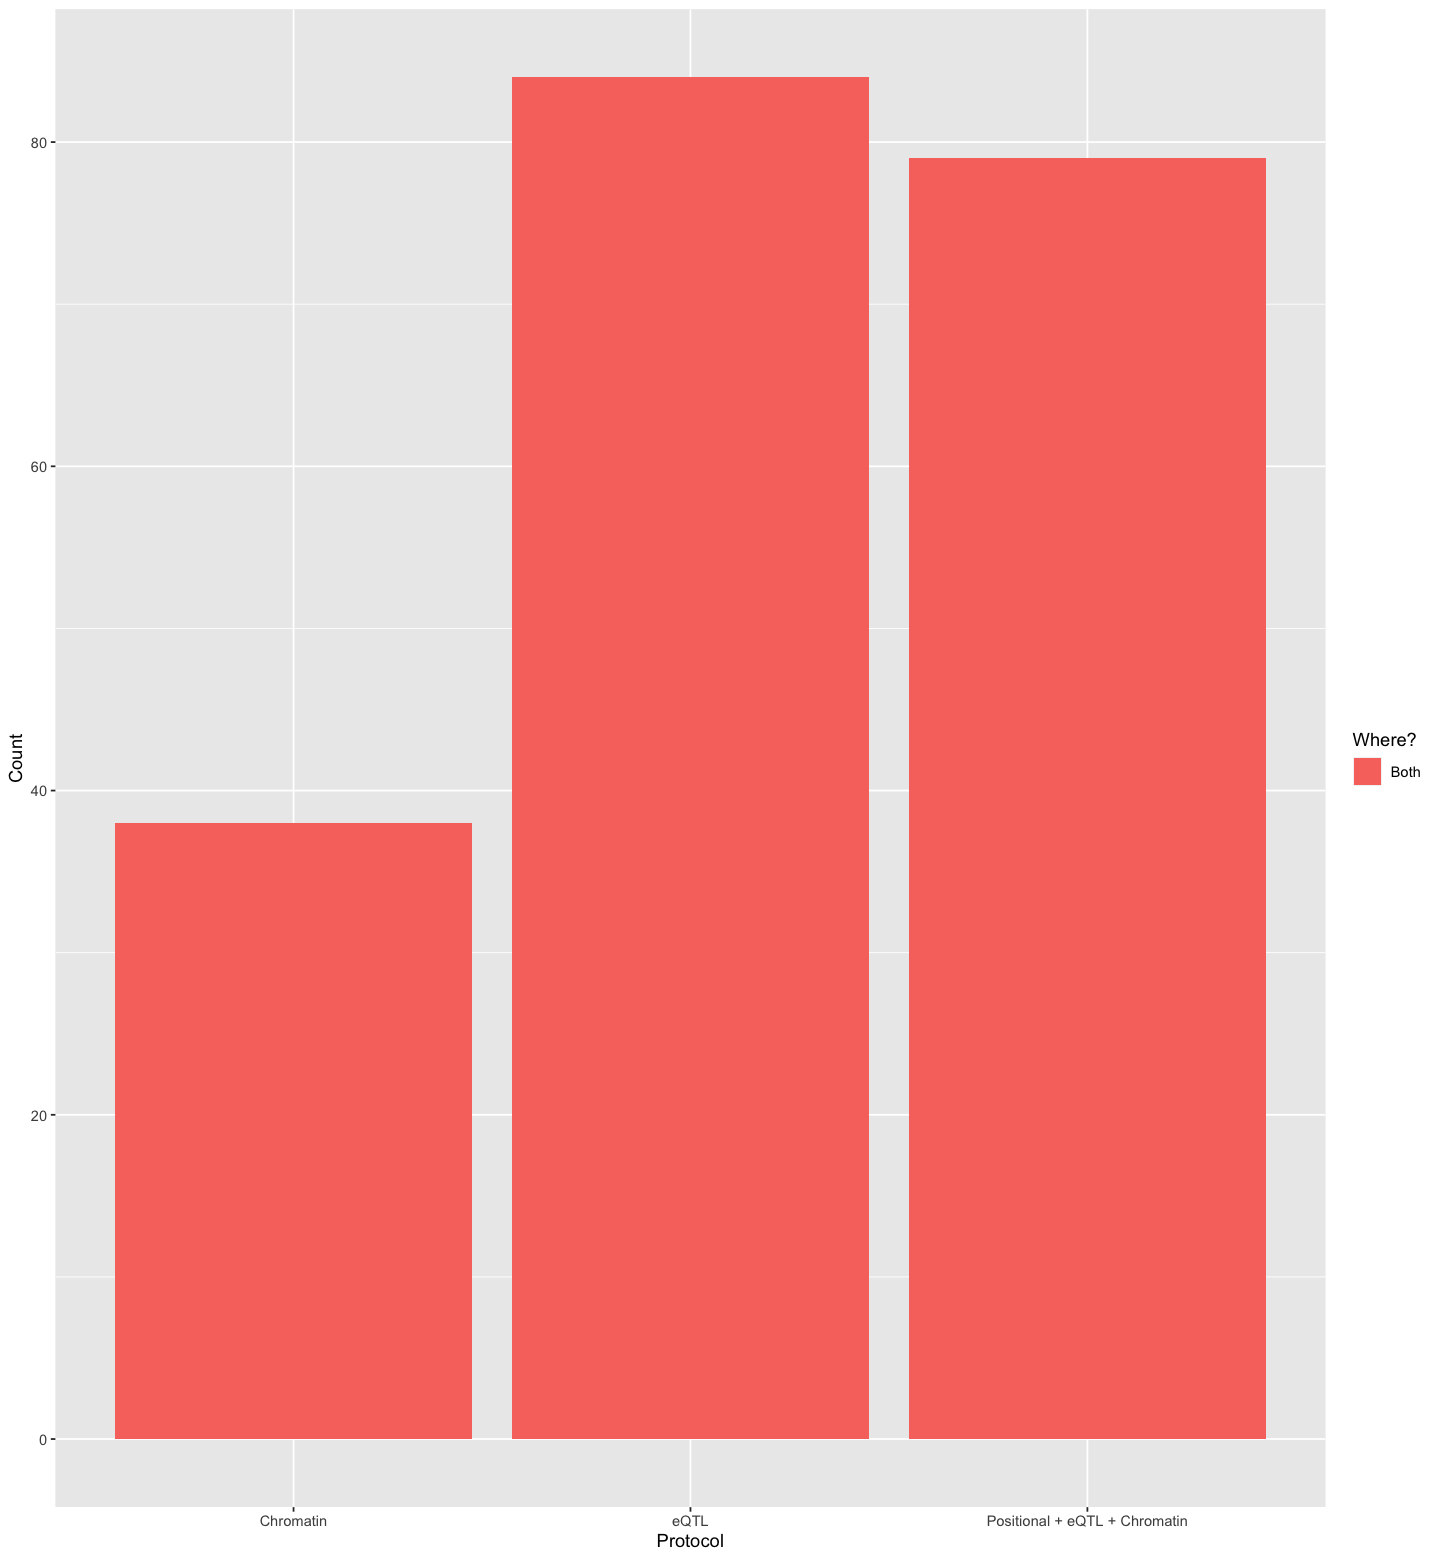

In [17]:
read_files <- function(tag, where) {
    before <- read_csv(glue('{rslt}/withBiofilter_filter/{tag}/sign_SNPpairs.txt'), col_types = 'ccdccc')
    after <- read_csv(glue('{rslt}/withBiofilter_filter/{tag}/PRS_adjusted_pval_add.txt'), col_types = 'ccd')

    full_join(before, after, by = c('SNP_1' = 'SNP1', 'SNP_2' = 'SNP2')) %>%
        mutate(new = ifelse(is.na(pvalue_uncorrected_MT), 'Only new', 'Only old'),
               new = ifelse(!is.na(PRS_adj_pval) & !is.na(pvalue_uncorrected_MT), 'Both', new),
               where = where)
}

pvals <- bind_rows(read_files('chromatin', 'Chromatin'),
                   read_files('eqtl', 'eQTL'),
#                    read_files('eqtl_chrom', 'eQTL +\nChromatin'),
                   read_files('eqtl_chrom_phys', 'Positional + eQTL + Chromatin'))

pvals %>%
    ggplot(aes(x = where, fill = new)) +
        geom_bar() +
        labs(x = 'Protocol', y = 'Count', fill = 'Where?')

## Main effects influence on epistasis detection

In [12]:
mh_plot <- function(protocol, tag) {

    gwais <- read_csv(glue('{rslt}/withBiofilter_filter/{protocol}/sign_SNPpairs.txt'), col_types = 'ccdccc')
    epi_snps <- c(gwais$SNP_1, gwais$SNP_2) %>% unique

    don <- gwas %>% 

      # Compute chromosome size
      group_by(chr) %>% 
      summarise(chr_len=max(pos)) %>% 

      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%

      # Add this info to the initial dataset
      left_join(gwas, ., by='chr') %>%

      # Add a cumulative position of each SNP
      arrange(chr, pos) %>%
      mutate(BPcum = pos + tot,
             epi_snp = snp %in% epi_snps)

    bf_threshold <- .05 / (nrow(gwas))
    y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
    axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )
    n_main <- filter(gwas, selected == 'Yes') %>% nrow
    n_epi <- length(epi_snps)

    ggplot(don, aes(x=BPcum, y=-log10(P))) +

        # Show all points
        geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +
        geom_point(data = filter(don, epi_snp), color='#2b2e4a', size=1.3) +

        # Add Bonferroni line
        geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

        # custom X axis:
        scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
        scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

        # Custom the theme:
        theme_bw() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          axis.title = element_text(size = 15),
          axis.text = element_text(size = 12),
          strip.text.y = element_text(size = 15),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) +
        labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'), 
             title = tag)
    
    }

mh_plt <- plot_grid(mh_plot('eqtl', 'eQTL'), 
                    mh_plot('chromatin', 'Chromatin'),
                    mh_plot('eqtl_chrom_phys', 'Positional + eQTL + Chromatin'),
                    nrow = 3)

In [64]:
pval_plt <- pvals %>%
    mutate(where = factor(where, levels = c('eQTL', 'Chromatin', 'Positional + eQTL + Chromatin'))) %>%
    ggplot(aes(x = -log10(PRS_adj_pval), y = -log10(pvalue_uncorrected_MT))) +
        geom_point() +
        geom_abline(slope = 1) +
        facet_wrap(. ~ where, ncol = 1) +
        labs(x = bquote('-log' [10]~'(PRS-adjusted P-value)'),
             y = bquote('-log' [10]~'(P-value)')) +
        theme_bw() +
        theme(text = element_text(size = 16))

In [8]:
get_mapped_genes <- function(genes, snps) {

    uniq_snp2gene <- read_csv(paste0(rslt, genes), col_types = 'cdccd') %>%
        separate_rows(SNP1, sep = ' ') %>%
        separate_rows(SNP2, sep = ' ') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = make_key(gene1, gene2),
               uniq_snp_id = make_key(SNP1, SNP2),
               sign_gene = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_gene) %>%
        unique

    uniq_snp <- read_csv(paste0(rslt, snps), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = make_key(SNP_1, SNP_2),
               uniq_gene_id = make_key(gene1, gene2),
               sign_snp = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, sign_snp) %>%
        unique
    
    full_join(uniq_snp, uniq_snp2gene, by = c("uniq_gene_id", "uniq_snp_id")) %>%
        mutate(sign_gene = ifelse(is.na(sign_gene), FALSE, TRUE),
               sign_snp = ifelse(is.na(sign_snp), FALSE, TRUE))
    
}

strenghtened_pairs <- filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT) %>%
    select(SNP_1, SNP_2) %>%
    unique %>%
    inner_join(gwas, by = c('SNP_1' = 'snp')) %>%
    inner_join(gwas, by = c('SNP_2' = 'snp'), suffix = c('_1', '_2')) %>%
    select(SNP_1, SNP_2, chr_1, chr_2) %>%
    mutate(uniq_snp_id = make_key(SNP_1, SNP_2)) %>%
    select(uniq_snp_id, chr_1, chr_2) %>%
    unique

strenghtened_gene <- bind_rows(get_mapped_genes('noFilter/sign_GenePairs.txt', 'noFilter/sign_SNPPairs.txt') %>% mutate(exp = 'Standard'),
          get_mapped_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/chromatin/sign_SNPPairs.txt') %>% mutate(exp = 'Chromatin'),
          get_mapped_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL'),
          get_mapped_genes('withBiofilter_filter/eqtl_chrom/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl_chrom/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL + Chromatin'),
          get_mapped_genes('withBiofilter_filter/eqtl_chrom_phys/sign_GenePairs_withoutThreshold.txt',
                           'withBiofilter_filter/eqtl_chrom_phys/sign_SNPPairs.txt') %>% mutate(exp = 'Positional + eQTL + Chromatin')) %>%
    select(uniq_gene_id, uniq_snp_id) %>%
    inner_join(strenghtened_pairs, by = "uniq_snp_id") %>%
    unique

ibd_genes <- read_tsv('../data/C0021390_disease_gda_summary.tsv',
                      col_types = cols(.default = col_character()))$Gene

str_snps_plt <- strenghtened_gene %>%
    select(-uniq_gene_id) %>%
    separate(uniq_snp_id, into = c('snp_1', 'snp_2'), sep = '_') %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray50', size = 3) +
        geom_nodes(size = 10, color = '#3490de') +
        geom_nodetext_repel(aes(label = name), size = 5.5) +
        theme_blank() +
        theme(legend.position = 'none') +
        theme(plot.title = element_text(size = 23, face = "bold")) +
        theme_transparent +
        scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
        scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

str_genes_plt <- strenghtened_gene %>%
    separate(uniq_gene_id, into = c('gene_1', 'gene_2'), sep = '_') %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    mutate(ibd = name %in% ibd_genes) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray50', size = 3) +
        geom_nodes(aes(size = ibd, shape = ibd), color = '#3f72af') +
        geom_nodetext_repel(aes(label = name), size = 5.5) +
        theme_blank() +
        theme(legend.position = 'none') +
        theme(plot.title = element_text(size = 23, face = "bold")) +
        theme_transparent +
        scale_size_manual(values = c('TRUE' = 13, 'FALSE' = 8)) +
        scale_shape_manual(values = c('TRUE' = 18, 'FALSE' = 16))

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


In [74]:
palette <- c('Positional' = 'white',
             'eQTL' = '#7fc97f',
             'Chromatin' = '#beaed4',
             'Standard' = '#fdc086',
             'eQTL + Chromatin' = '#a65628',
             'Positional + eQTL + Chromatin' = '#e31a1c',
             'Positional + eQTL' = '#63B4B8',
             'Positional + Chromatin' = '#C6D57E')

get_snps <- function(path) {
    
    intx <- read_csv(paste0(rslt, path), col_types = 'ccdccc')

    c(intx$SNP_1, intx$SNP_2) %>%
        unique
    
}

all_snps <- c(get_snps('withBiofilter_filter/eqtl/sign_SNPPairs.txt'),
               get_snps('withBiofilter_filter/chromatin/sign_SNPPairs.txt'),
               get_snps('noFilter/sign_SNPPairs.txt'),
               get_snps('withBiofilter_filter/eqtl_chrom/sign_SNPPairs.txt'),
               get_snps('withBiofilter_filter/eqtl_chrom_phys/sign_SNPPairs.txt'),
               get_snps('withBiofilter_filter/eqtl_positional/sign_SNPPairs.txt'),
               get_snps('withBiofilter_filter/chromatin_positional/sign_SNPPairs.txt')) %>%
    unique %>%
    sort


add_edges <- function(graph, df) {

    res_net <- strenghtened_gene %>%
        separate(uniq_snp_id, into = c('to', 'from'), sep = '_')
    
    bind_edges(graph, res_net)

}

plot_circular <- function(graph, label='') {
    
    ggraph(graph, layout = 'linear', circular = TRUE) + 
        geom_edge_arc(color = "#ECAC5D", edge_width = 3) + 
        geom_edge_arc(color = 'gray50', edge_width = .5) +
        geom_node_text(aes(label=name, angle = angle), 
                       size = 3, hjust = "inward") +
        geom_node_point(size = 4, color = 'black', alpha = 0.2) +
        theme(strip.text.x = element_text(size = 35),
              plot.title = element_text(size = 35)) +
        scale_edge_color_manual(values = palette) +
        theme_transparent +
        ggtitle(label)
    
}

options(repr.plot.width=21, repr.plot.height=45)
nodes <- tbl_graph() %>%
    bind_nodes(data.frame(name = all_snps)) %>%
    mutate(idx = seq(n()),
           angle = 90 - idx * 360 / max(idx),
           angle = ifelse(idx > (max(idx) / 4), - (idx - (max(idx) / 4)) * 360 / max(idx), angle),
           angle = ifelse(idx > (max(idx) / 2), 90 - (idx - (max(idx) / 2)) * 360 / max(idx), angle),
           angle = ifelse(idx > (3 * max(idx) / 4), 270 - idx * 360 / max(idx), angle))

str_snps_plt <- nodes %>%
    add_edges(strenghtened_gene) %>%
    plot_circular +
        theme(legend.position = 'none')

In [72]:
get_genes <- function(path) {
    
    intx <- read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ')

    c(intx$gene_a, intx$gene_b) %>%
        unique
    
}

all_genes <- c(get_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt'),
               get_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt'),
               get_genes('noFilter/sign_GenePairs.txt'),
               get_genes('withBiofilter_filter/eqtl_chrom/sign_GenePairs_withoutThreshold.txt'),
               get_genes('withBiofilter_filter/eqtl_chrom_phys/sign_GenePairs_withoutThreshold.txt'),
               get_genes('withBiofilter_filter/eqtl_positional/sign_GenePairs.txt'),
               get_genes('withBiofilter_filter/chromatin_positional/sign_GenePairs.txt')) %>%
    unique %>%
    sort

add_edges <- function(graph, df) {

    res_net <- strenghtened_gene %>%
        separate(uniq_gene_id, into = c('to', 'from'), sep = '_')
    
    bind_edges(graph, res_net)

}

plot_circular <- function(graph, label='') {
    
    ggraph(graph, layout = 'linear', circular = TRUE) + 
        geom_edge_arc(color = "#ECAC5D", edge_width = 5) +
        geom_edge_arc(color = 'gray50', edge_width = .5) + 
        geom_node_text(aes(label=name, angle = angle), 
                       size = 5, hjust = "inward") +
        geom_node_point(aes(color = ibd), size = 8, alpha = 0.3) +
        theme(strip.text.x = element_text(size = 35),
              plot.title = element_text(size = 35)) +
        scale_edge_color_manual(values = palette) +
        scale_color_manual(values = c('TRUE' = 'red', 'FALSE' = 'black')) +
        theme_transparent +
        ggtitle(label)
    
}

options(repr.plot.width=30, repr.plot.height=16)
nodes <- tbl_graph() %>%
    bind_nodes(data.frame(name = all_genes)) %>%
    mutate(ibd = name %in% ibd_genes,
           idx = seq(n()),
           angle = 90 - idx * 360 / max(idx),
           angle = ifelse(idx > (max(idx) / 4), - (idx - (max(idx) / 4)) * 360 / max(idx), angle),
           angle = ifelse(idx > (max(idx) / 2), 90 - (idx - (max(idx) / 2)) * 360 / max(idx), angle),
           angle = ifelse(idx > (3 * max(idx) / 4), 270 - idx * 360 / max(idx), angle))

str_genes_plt <-nodes %>%
    add_edges(strenghtened_gene) %>%
    plot_circular +
        theme(legend.position = 'none')

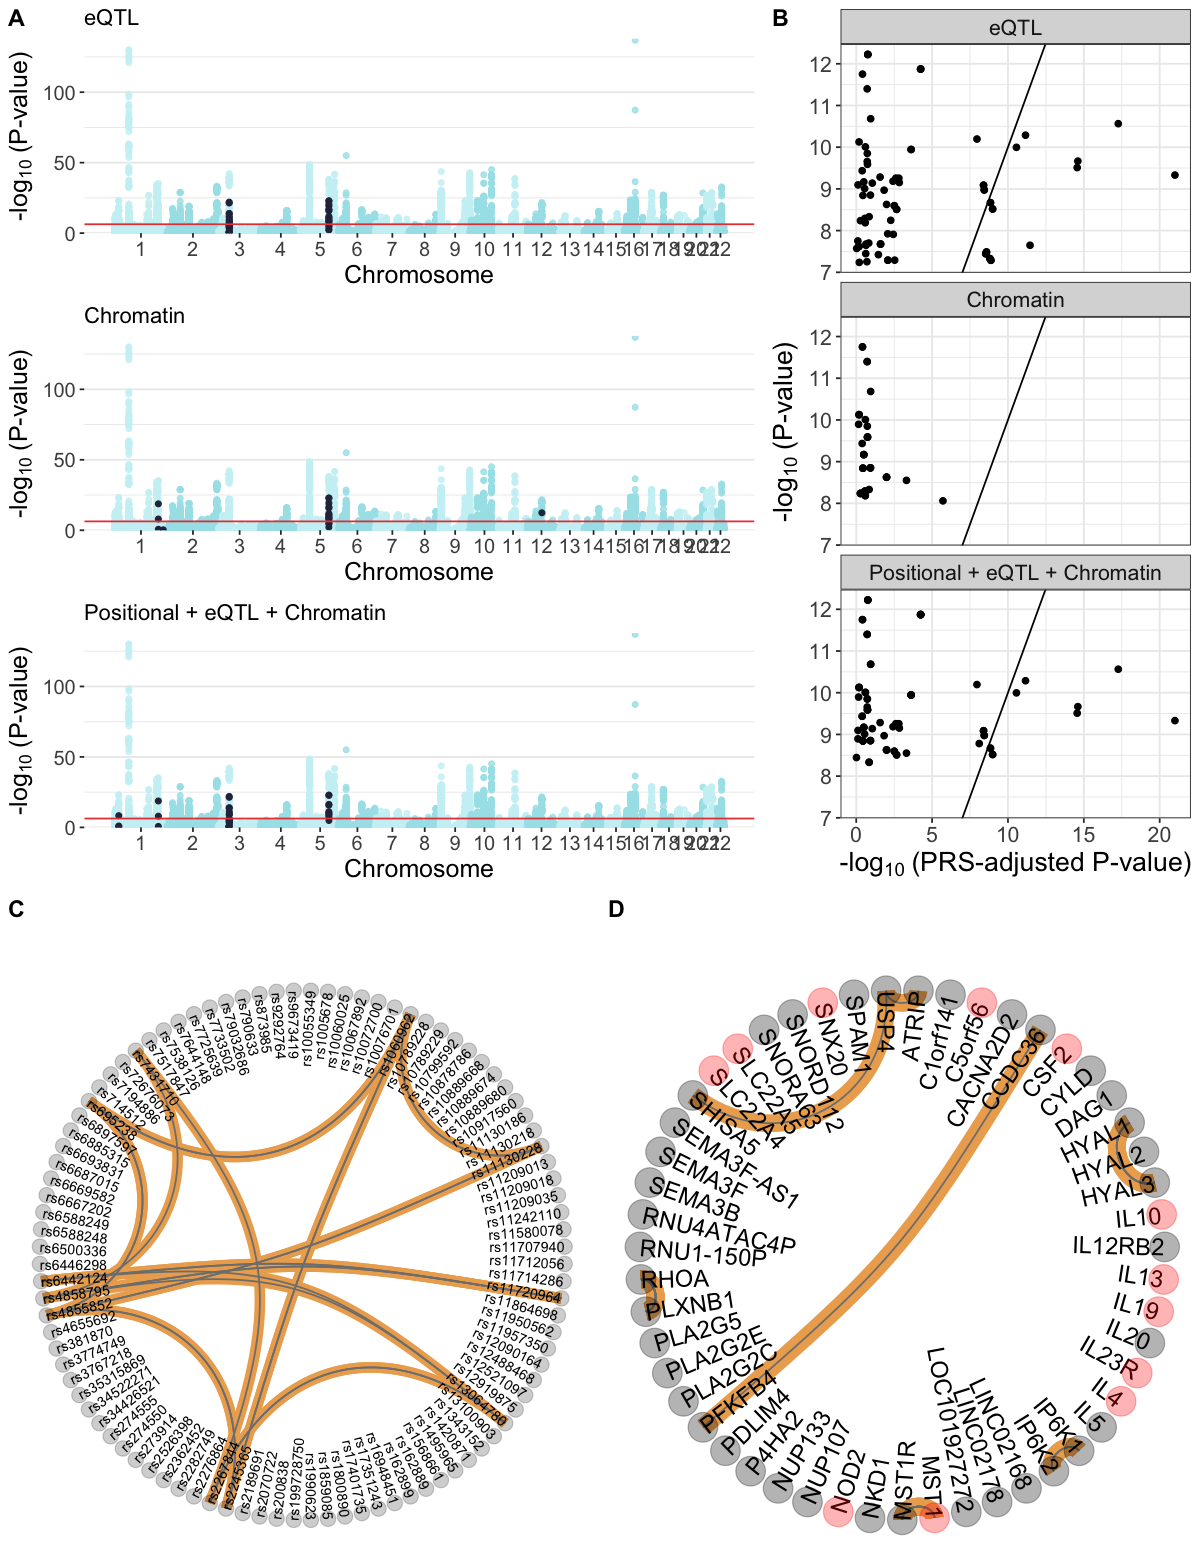

In [75]:
options(repr.plot.width=10, repr.plot.height=13)
plot_grid(plot_grid(mh_plt, pval_plt, ncol = 2, labels = c('A','B'), rel_widths = c(1.75, 1)),
          plot_grid(str_snps_plt, str_genes_plt, ncol = 2, labels = c('C','D')), 
          nrow = 2, rel_heights = c(2, 1.5))
ggsave('fig/prs_adjusted_vs_unadjusted.png', width=10, height=13)

In [23]:
# unique SNPs in Pairs strengthened by PRS-adjustment
c(filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT)$SNP_1,
  filter(pvals, PRS_adj_pval < pvalue_uncorrected_MT)$SNP_2) %>%
    unique

[1] "rs11130228" "rs2245365"  "rs2267844"  "rs4855852"  "rs4858795" 
 [6] "rs6442124"  "rs695238"   "rs7431710"  "rs1060962"  "rs13064780"
[11] "rs11720964"